# Collegedunia -  Data Analysis Assesment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point
from sklearn.impute import KNNImputer
from geopy.distance import geodesic


# Geospatial Analysis:
## Utilize distribution_centers.csv and users.csv for mapping and analysing the geographic distribution of users and distribution centers.


In [2]:
dc = pd.read_csv('./data/distribution_centers.csv')
users = pd.read_csv('./data/users.csv')
# users = users.sample(10000,replace = False)

In [3]:
dc.head(3)

,id,name,latitude,longitude
0,1,Memphis TN,35.1174,-89.9711
1,2,Chicago IL,41.8369,-87.6847
2,3,Houston TX,29.7604,-95.3698


In [4]:
users.head(3)

,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at
0,457,Timothy,Bush,timothybush@example.net,65,M,Acre,87620 Johnson Hills,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Search,2022-07-19 13:51:00+00:00
1,6578,Elizabeth,Martinez,elizabethmartinez@example.com,34,F,Acre,1705 Nielsen Land,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Search,2023-11-08 18:49:00+00:00
2,36280,Christopher,Mendoza,christophermendoza@example.net,13,M,Acre,125 Turner Isle Apt. 264,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Email,2019-08-24 06:10:00+00:00


In [5]:
print(dc.shape)
print(users.shape)

(10, 4)
(100000, 15)


In [6]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10 non-null     int64  
 1   name       10 non-null     object 
 2   latitude   10 non-null     float64
 3   longitude  10 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 448.0+ bytes


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              100000 non-null  int64  
 1   first_name      100000 non-null  object 
 2   last_name       100000 non-null  object 
 3   email           100000 non-null  object 
 4   age             100000 non-null  int64  
 5   gender          100000 non-null  object 
 6   state           100000 non-null  object 
 7   street_address  100000 non-null  object 
 8   postal_code     100000 non-null  object 
 9   city            99042 non-null   object 
 10  country         100000 non-null  object 
 11  latitude        100000 non-null  float64
 12  longitude       100000 non-null  float64
 13  traffic_source  100000 non-null  object 
 14  created_at      100000 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 11.4+ MB


In [8]:
print(dc.isnull().sum().sum())

0


In [9]:
print(users.isnull().sum())

id                  0
first_name          0
last_name           0
email               0
age                 0
gender              0
state               0
street_address      0
postal_code         0
city              958
country             0
latitude            0
longitude           0
traffic_source      0
created_at          0
dtype: int64


### We have few city with null values, let us find where these cities are

In [10]:
users['city_null'] = users['city'].apply(lambda x: 1 if pd.isnull(x) else 0)

### The above function will act as a hue in out future plot which will help us in easy identification of the location of the city with null values

In [11]:
### Function to plot map

In [12]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

def plot_users_on_map(users_df,title):
    # Create a GeoDataFrame
    geometry = [Point(xy) for xy in zip(users_df['longitude'], users_df['latitude'])]
    gdf = gpd.GeoDataFrame(users_df, geometry=geometry, crs='EPSG:4326')

    # Load world map with country boundaries
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    world.plot(ax=ax, color='lightgrey', edgecolor='black')
    gdf.plot(ax=ax, markersize=10, column='city_null', legend=False, cmap='coolwarm', marker='o', label='Individuals')
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

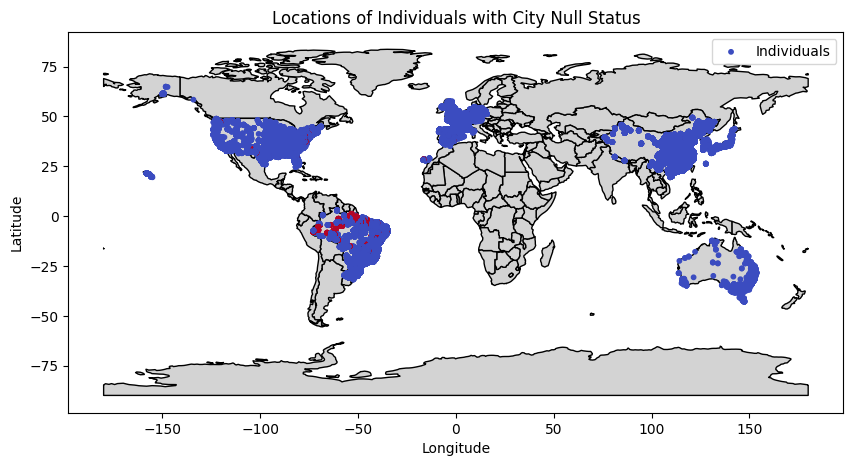

In [13]:
plot_users_on_map(users,'Locations of Individuals with City Null Status')

## Inference : Majority cities with null values are from south american continent.

In [14]:
import folium

# Create a map centered at a certain location
m = folium.Map(location=[37.0902, -95.7129], zoom_start=3)  # Centered at the United States

# Add markers for each distribution center
for index, row in dc.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row['name']).add_to(m)

# Save the map as an HTML file
# m.save("distribution_centers_map.html")
m

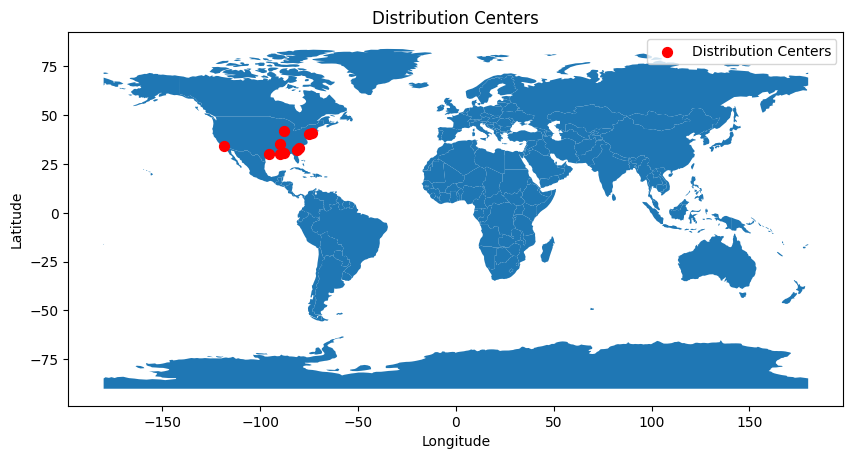

In [15]:
geometry = [Point(xy) for xy in zip(dc['longitude'], dc['latitude'])]
gdf = gpd.GeoDataFrame(dc, geometry=geometry)

# Plot the distribution centers
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6))
gdf.plot(ax=ax, color='red', markersize=50, label='Distribution Centers', marker='o')
ax.set_title('Distribution Centers')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

## Based on the provided information in regarding distribution centers, it is apparent that the information pertains solely to distribution centers within the United States. Therefore, it would be more logical to focus our analysis on data pertaining to users from the United States.

### Filtering users from the US based on latitude and longitude

In [16]:
north_america_lat_bounds = (10, 70)   # Latitude range for North America
north_america_lon_bounds = (-180, -52)  # Longitude range for North America

# Filter users based on North American latitude and longitude boundaries
filtered_users = users[
    (users['latitude'] >= north_america_lat_bounds[0]) & 
    (users['latitude'] <= north_america_lat_bounds[1]) & 
    (users['longitude'] >= north_america_lon_bounds[0]) & 
    (users['longitude'] <= north_america_lon_bounds[1])
]

In [17]:
filtered_users.shape

(22522, 16)

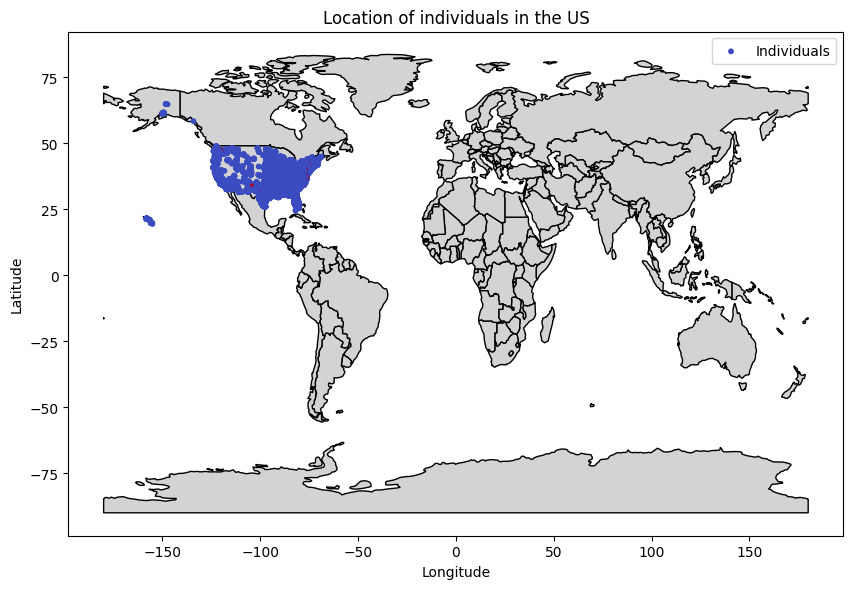

In [18]:
plot_users_on_map(filtered_users,"Location of individuals in the US")

# Taking just a small subset due to PC limitations
# The sample is a good representatin of population -  Checked

In [19]:
# Create a map centered at a certain location
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)  # Centered at the United States
temp = filtered_users.sample(200, replace=False)
# taking just a small subset due to PC limitations
# Add markers for each distribution center
for index, row in temp.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(m)

# Save the map as an HTML file
m

In [20]:
## Checking the null values in filtered data
filtered_users.isnull().sum() * 100 / filtered_users.shape[0]

id                0.000000
first_name        0.000000
last_name         0.000000
email             0.000000
age               0.000000
gender            0.000000
state             0.000000
street_address    0.000000
postal_code       0.000000
city              0.754818
country           0.000000
latitude          0.000000
longitude         0.000000
traffic_source    0.000000
created_at        0.000000
city_null         0.000000
dtype: float64

### City has a few null values, but this <span style="color:red">**DOES NOT**</span> even add up to 1% of the overall data hence I am imputing the city column with mode to make analysis simpler.

In [21]:
# imputing the null values with the mode
mode_city = filtered_users['city'].mode()[0]
filtered_users['city'].fillna(mode_city, inplace=True)

In [22]:
filtered_users.isnull().sum().sum()

0

## Calculating Density

In [23]:
# Create a map centered at a certain location
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)  # Centered at the United States
temp = filtered_users.sample(200, replace=False)
# taking just a small subset due to PC limitations
# Add markers for each distribution center
for index, row in temp.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(m)

# Save the map as an HTML file
for i,row in dc.iterrows():
    folium.Circle(
        location=[row['latitude'],row['longitude']],
        radius=300000, # in meters 300km
        popup="Salt Lake",
        color="blue",
        fill=True,
    ).add_to(m)
m

In [24]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# Function to calculate distance between two points using Haversine formula
def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # approximate radius of Earth in km
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

# Function to calculate density of users around each distribution center
def calculate_density(dc, users, radius_km):
    density_results = []

    for index, row in dc.iterrows():
        dc_id = row['id']
        dc_name = row['name']
        dc_lat = row['latitude']
        dc_lon = row['longitude']

        user_count = 0
        for _, user_row in users.iterrows():
            user_lat = user_row['latitude']
            user_lon = user_row['longitude']
            distance = calculate_distance(dc_lat, dc_lon, user_lat, user_lon)
            if distance <= radius_km:
                user_count += 1
        
        # Calculate density
        area = np.pi * (radius_km ** 2)
        density = user_count / area

        density_results.append({'id': dc_id, 'name': dc_name, 'density': density})

    return pd.DataFrame(density_results)
# https://www.movable-type.co.uk/scripts/latlong.html

In [25]:
# Calculate density of users around each distribution center
radius_km = 300
density_df_300 = calculate_density(dc, filtered_users, radius_km)

In [26]:
# distance = geodesic((dc_lat, dc_lon), (user_lat, user_lon)).kilometers
# takes more time

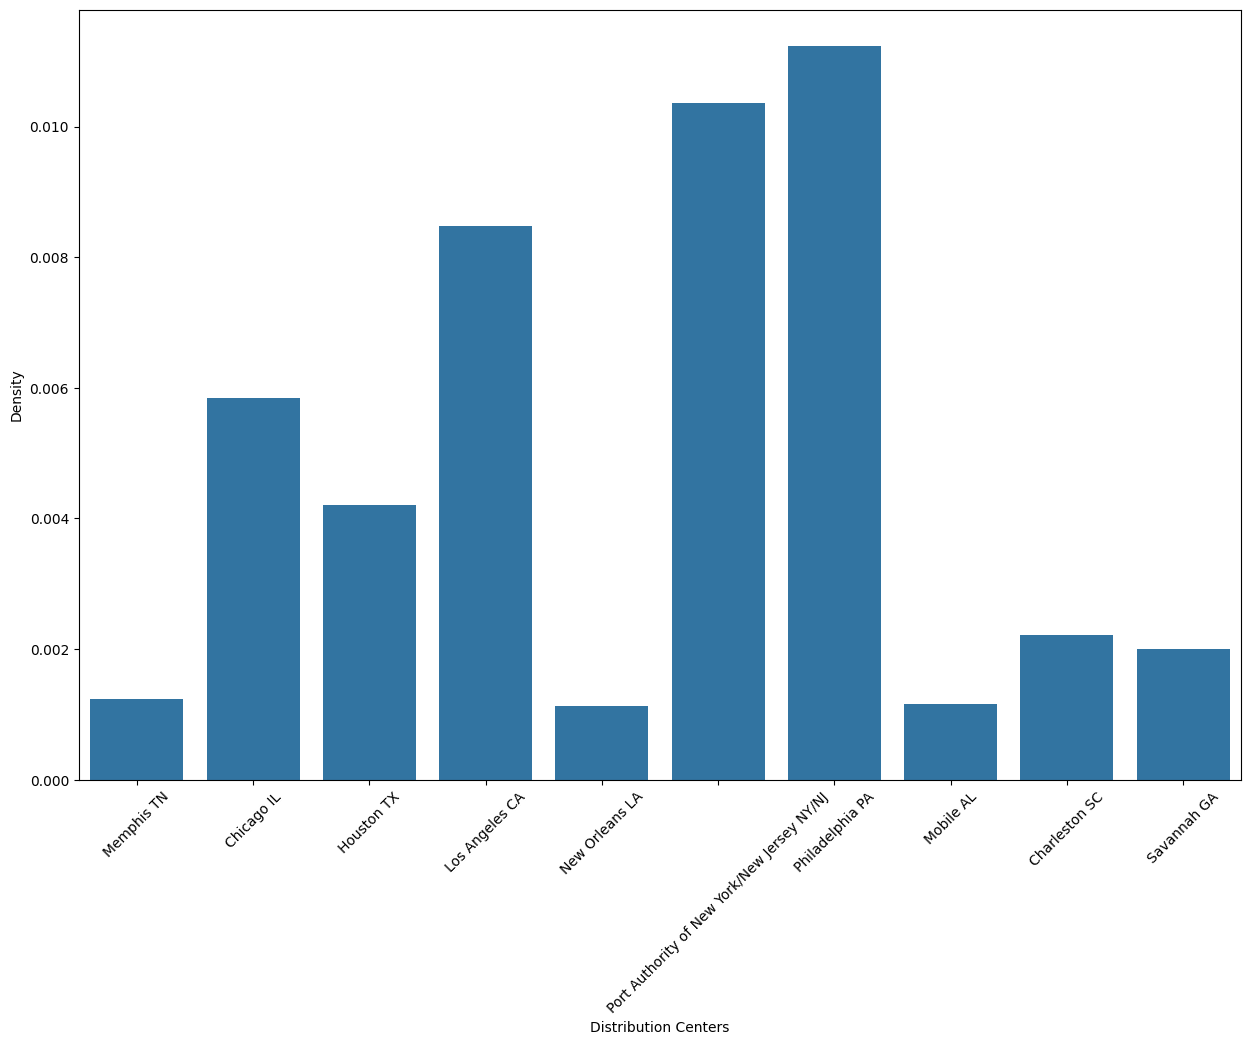

In [27]:
plt.figure(figsize=(15,10))
sns.barplot(x = density_df_300['name'],y = density_df_300['density'])
plt.xticks(rotation=45)
plt.xlabel('Distribution Centers') 
plt.ylabel('Density') 
plt.show()

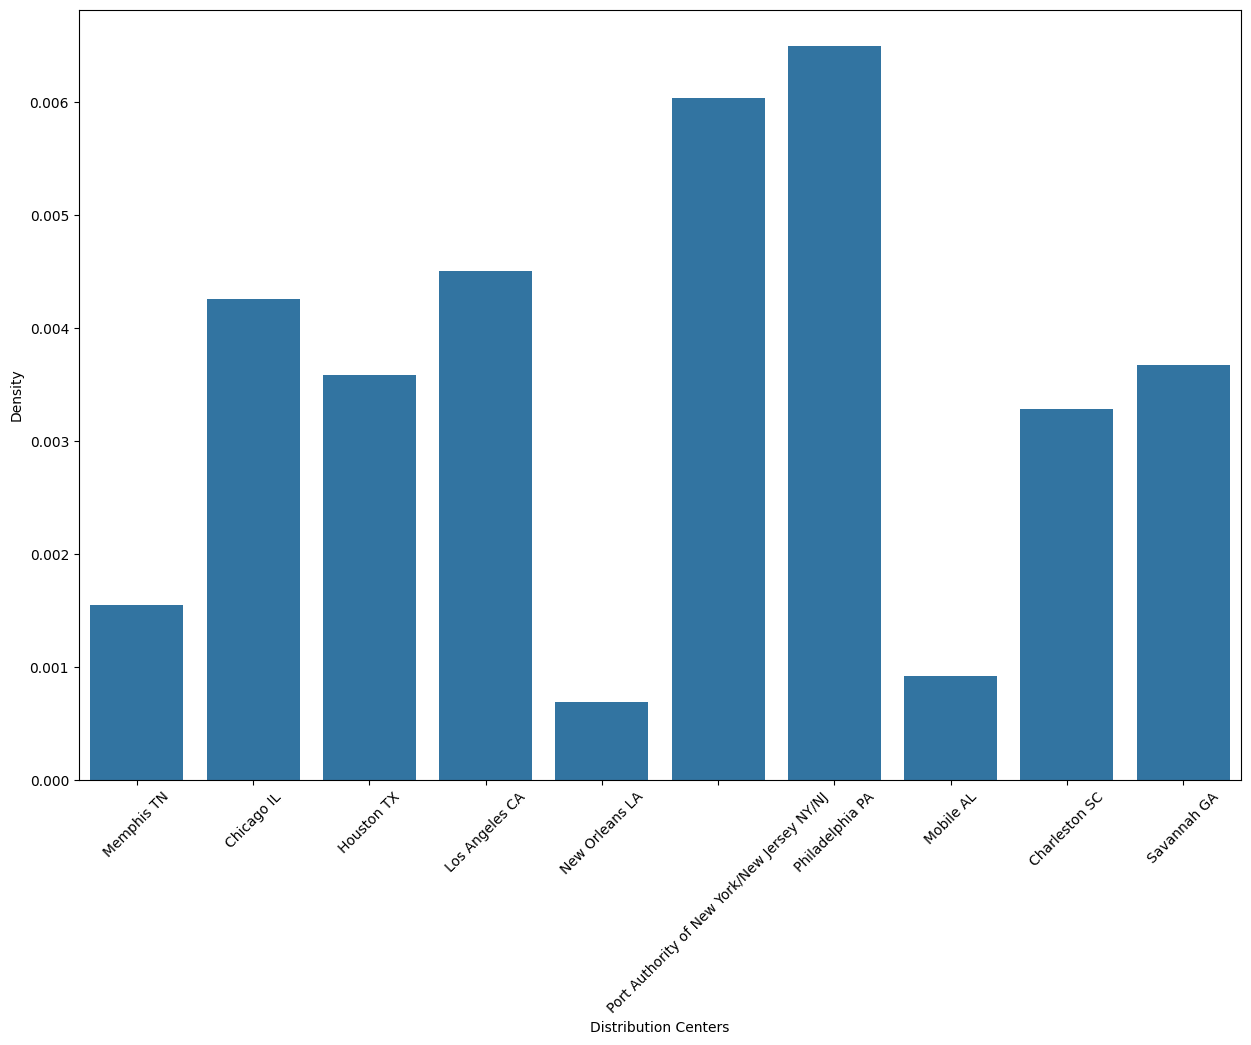

In [28]:
# Calculate density of users around each distribution center
radius_km = 450
density_df_450 = calculate_density(dc, filtered_users, radius_km)
plt.figure(figsize=(15,10))
sns.barplot(x = density_df_450['name'],y = density_df_450['density'])
plt.xticks(rotation=45)
plt.xlabel('Distribution Centers') 
plt.ylabel('Density') 
plt.show()

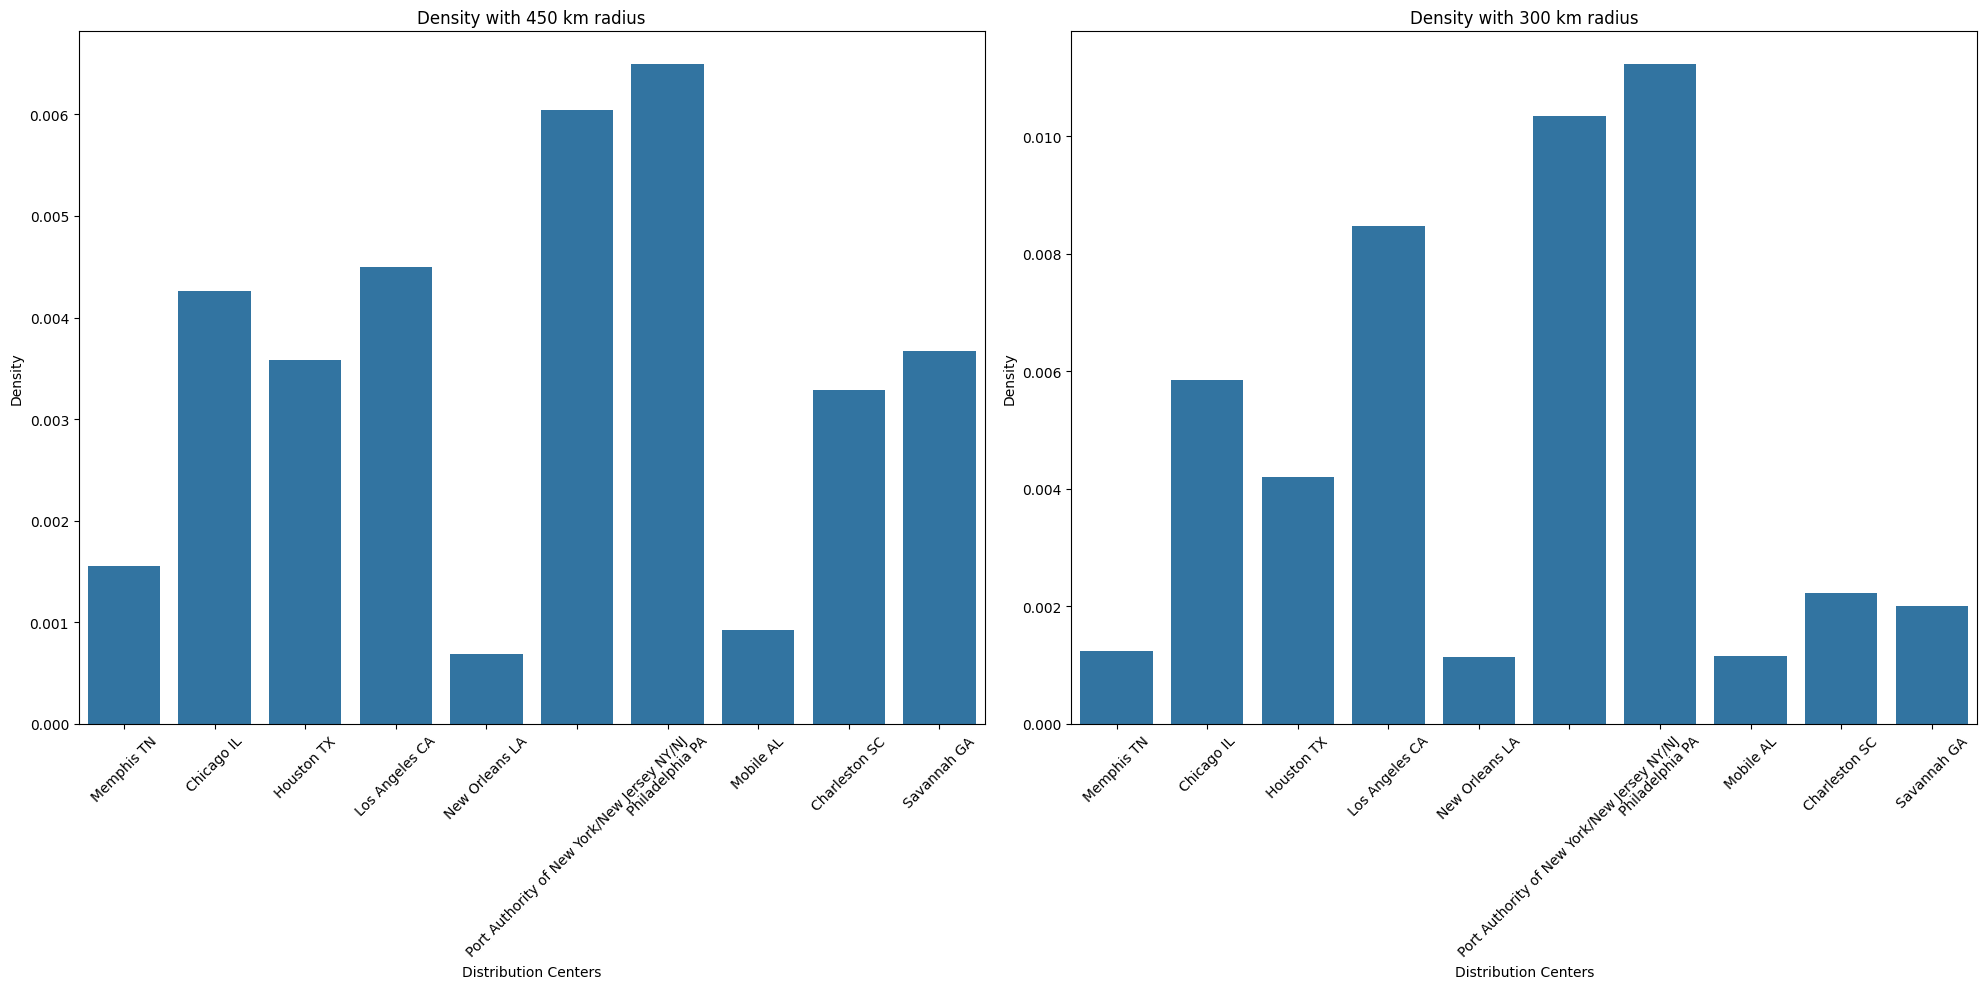

In [29]:
plt.figure(figsize=(20, 10))

# First subplot
plt.subplot(1, 2, 1)
sns.barplot(x=density_df_450['name'], y=density_df_450['density'])
plt.xticks(rotation=45)
plt.xlabel('Distribution Centers')
plt.ylabel('Density')
plt.title('Density with 450 km radius')

# Second subplot
plt.subplot(1, 2, 2)
sns.barplot(x=density_df_300['name'], y=density_df_300['density'])
plt.xticks(rotation=45)
plt.xlabel('Distribution Centers')
plt.ylabel('Density')
plt.title('Density with 300 km radius')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## "Port Authority of New York/New Jersey NY/NJ" and "Philadelphia PA" has the highest user density amonng all distribution centers

In [30]:
## In both case (300km and 450 km as radius, the result appear to be similar)

In [31]:
# Create a map centered at a certain location
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)  # Centered at the United States
temp = filtered_users.sample(200, replace=False)
# taking just a small subset due to PC limitations
# Cheaked that the sample is a good representatino of population
# Add markers for each distribution center
for index, row in temp.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(m)

# Save the map as an HTML file
for i,row in dc.iterrows():
    folium.Circle(
        location=[row['latitude'],row['longitude']],
        radius=450000, # in meters 300km
        popup="Salt Lake",
        color="blue",
        fill=True,
    ).add_to(m)
m

## The map clearly indicates that the distribution centers experience high population density in the Los Angeles area and across the eastern United States.
## Implying the need of more distribution centers in remaining parts (north western parts, hawaii)